# Benchmark main Jupyter notebook

## Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from tst.loss import OZELoss

from src.dataset import OzeEvaluationDataset, OzeNPZDataset
from src.lstm_tsp import LSTMTimeSeriesPredictor
from src.transformer_tsp import TransformerTimeSeriesPredictor
from src.utils import npz_check

## Construct and configure the time series predictor

In [2]:
tsp = LSTMTimeSeriesPredictor()
# tsp = TransformerTimeSeriesPredictor()

## Load the dataset

In [3]:
dataset = OzeNPZDataset(dataset_path=npz_check(Path('datasets'), 'dataset'), labels_path="labels.json")

## Train the benchmark

In [4]:
hist_loss = tsp.fit(dataset, loss_function=OZELoss(alpha=0.3))

[Epoch   5/5]: 100%|██████████| 7500/7500 [00:24<00:00, 307.73it/s, loss=0.00671]
model exported to model_2020_05_23__222450.pth with loss 0.006709



### Plot the results for a training example

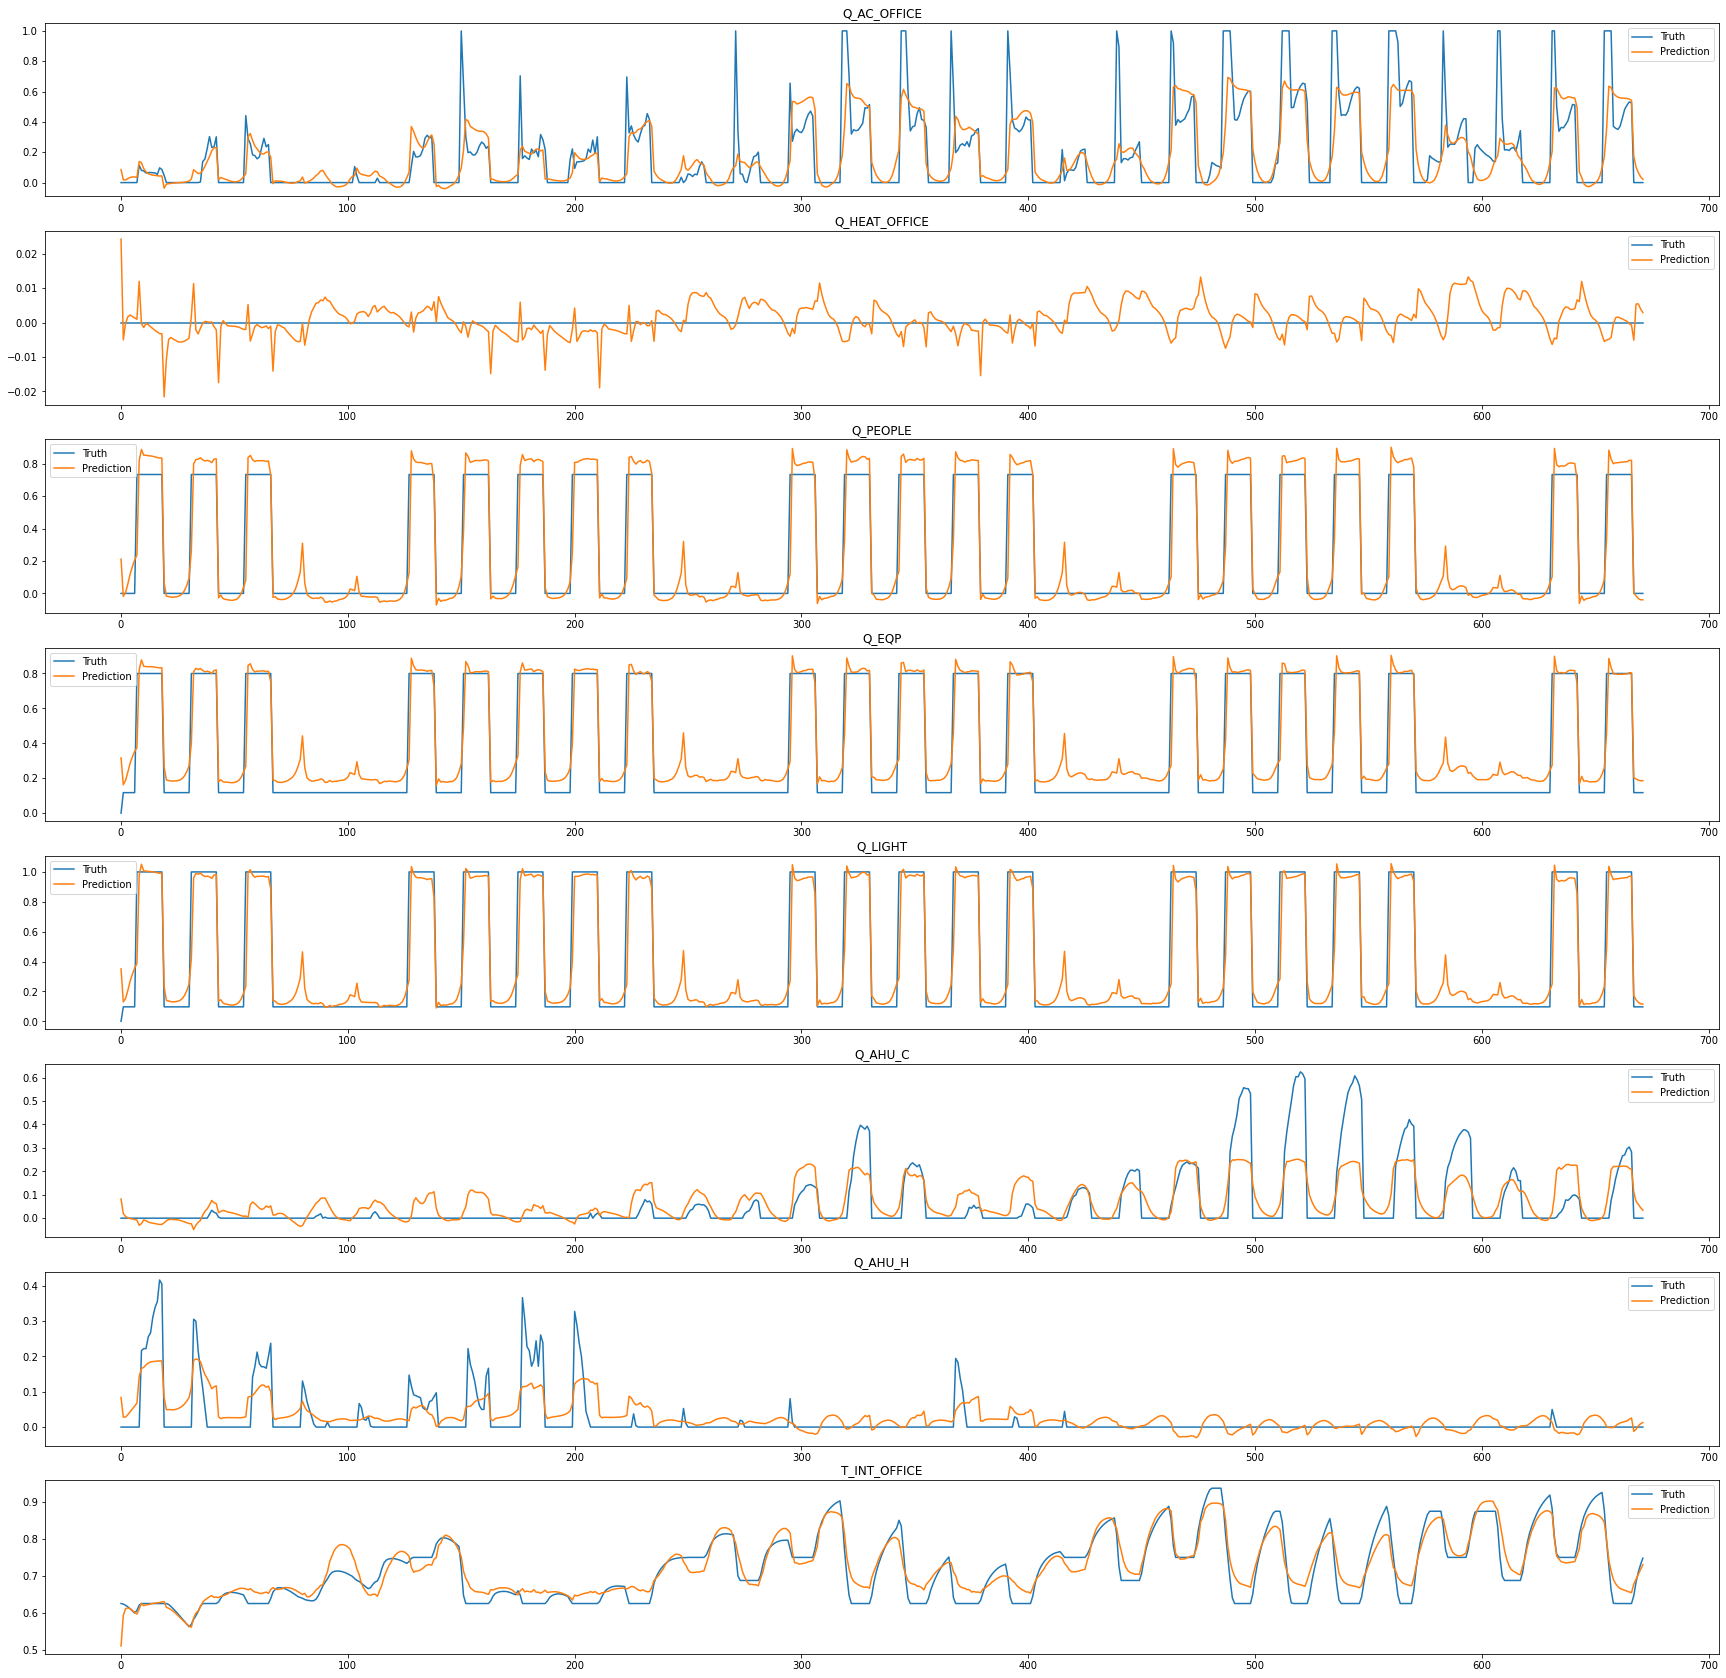

In [5]:
# Select training example
idx = np.random.randint(0, len(tsp.dataloader.dataset))
x, y = tsp.dataloader.dataset[idx]

# Run predictions
netout = tsp.predict(x)

plt.figure(figsize=(30, 30))
d_output = netout.shape[2]
for idx_output_var in range(d_output):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[0, :, idx_output_var]

    plt.subplot(d_output, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(tsp.dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

In [6]:
K = dataset.time_series_length
dataset_eval = OzeEvaluationDataset("datasets/x_test_QK7dVsy.csv", K, labels_path="labels.json")
dataset_eval_length = len(dataset_eval)

### Run prediction

In [7]:
predictions = np.zeros((dataset_eval_length, K, d_output))
m, M = tsp.dataloader.dataset.m, tsp.dataloader.dataset.M
for idx, line in tqdm(enumerate(dataset_eval), total=dataset_eval_length):
    # Run prediction
    netout = tsp.predict(line)

    # De-normalize output
    output = netout * (M - m + np.finfo(float).eps) + m
    predictions[idx] = output

100%|██████████| 500/500 [00:20<00:00, 23.93it/s]


### Export as csv

In [8]:
lines_output = predictions.reshape((dataset_eval_length, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

df = pd.DataFrame(lines_output, columns=csv_header)
df.insert(0, 'index', df.index + len(dataset))
df.to_csv('y_bench.csv', index=False)